done by: https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/2019_opens_clean.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [20]:
# Add a feature with random values to interpret results
np.random.seed(seed = 42)
df['RANDOM'] = np.random.normal(size = len(df))

# dataframe without benchmarks or height & weight
scores_cols = ['competitorid', 'gender', 'age', 'overallrank', 'is_scaled', \
               'scaled_1', 'scaled_2', 'scaled_3', 'scaled_4', 'scaled_5', \
               'time_2','time_3','time_4','time_5', \
               'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
               'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total', \
               'w3_hspu_status', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
               'w4_bmu_status', 'w4_tiebreak', 'w5_reps_total', 'RANDOM']
scores_m_rx_cols = ['competitorid', 'age', 'overallrank', \
               'time_2','time_3','time_4','time_5', \
               'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
               'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total', \
               'w3_hspu_status', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
               'w4_bmu_status', 'w4_tiebreak', 'w5_reps_total', 'RANDOM']
df_scores = df[scores_cols]

# drop rows with missing age values
df_scores = df_scores[df_scores['age'].notna()]
# keep just rows with all 5 workouts participated
df_scores = df_scores[df_scores['w1_reps_total'].notna()]
df_scores = df_scores[df_scores['w2_reps_total'].notna()]
df_scores = df_scores[df_scores['w3_reps_total'].notna()]
df_scores = df_scores[df_scores['w4_reps_total'].notna()]
df_scores = df_scores[df_scores['w5_reps_total'].notna()]
# drop rows with missing time values
df_scores = df_scores[df_scores['time_2'].notna()]
df_scores = df_scores[df_scores['time_3'].notna()]
df_scores = df_scores[df_scores['time_4'].notna()]
df_scores = df_scores[df_scores['time_5'].notna()]
# set missing tiebreak values to zero
df_scores['w2_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w3_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w4_tiebreak'].replace(np.NaN,0,inplace=True)
# replace categorical values with integer 1/0
df_scores['gender'].replace(['M','F'],[1,0],inplace=True)
df_scores['w3_hspu_status'].replace([1.0,0.0],[1,0],inplace=True)
df_scores['w4_bmu_status'].replace([1.0,0.0],[1,0],inplace=True)

df_scores_m_rx = df_scores[
    (df_scores['gender']==1) &
    (df_scores['scaled_1']==0) &
    (df_scores['scaled_2']==0) &
    (df_scores['scaled_3']==0) &
    (df_scores['scaled_4']==0) &
    (df_scores['scaled_5']==0)
]
df_scores_m_rx = df_scores_m_rx[scores_m_rx_cols]

In [22]:
train_set_sc, test_set_sc = train_test_split(df_scores, test_size=0.3, random_state=42)
train_set_sc_mrx, test_set_sc_mrx = train_test_split(df_scores_m_rx, test_size=0.3, random_state=42)

y_sc = df_scores['overallrank']
X_sc = df_scores.drop(axis=1,columns='overallrank')
y_sc_mrx = df_scores_m_rx['overallrank']
X_sc_mrx = df_scores_m_rx.drop(axis=1,columns='overallrank')

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, random_state=42)
X_train_sc_mrx, X_test_sc_mrx, y_train_sc_mrx, y_test_sc_mrx = train_test_split(X_sc_mrx, y_sc_mrx, random_state=42)

scale_cols = ['competitorid','age','time_2','time_3', \
              'time_4', 'time_5', 'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
              'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
              'w3_reps_total', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
              'w4_tiebreak', 'w5_reps_total'
             ]

scaler = StandardScaler()
X_train_scaled_sc = scaler.fit_transform(X_train_sc[scale_cols])
X_test_scaled_sc = scaler.transform(X_test_sc[scale_cols])
X_train_scaled_sc_mrx = scaler.fit_transform(X_train_sc_mrx[scale_cols])
X_test_scaled_sc_mrx = scaler.transform(X_test_sc_mrx[scale_cols])

X_train_preprocessed_sc_mrx = np.concatenate([X_train_scaled_sc_mrx, X_train_sc_mrx.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_sc_mrx = np.concatenate([X_test_scaled_sc_mrx, X_test_sc_mrx.drop(scale_cols, axis=1)], axis=1)

## Coefficients as Feature Importance

In [23]:
model = RandomForestRegressor()
model.fit(X_train_preprocessed_sc_mrx, y_train_sc_mrx)

RandomForestRegressor()

In [24]:
importance = model.feature_importances_

In [14]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

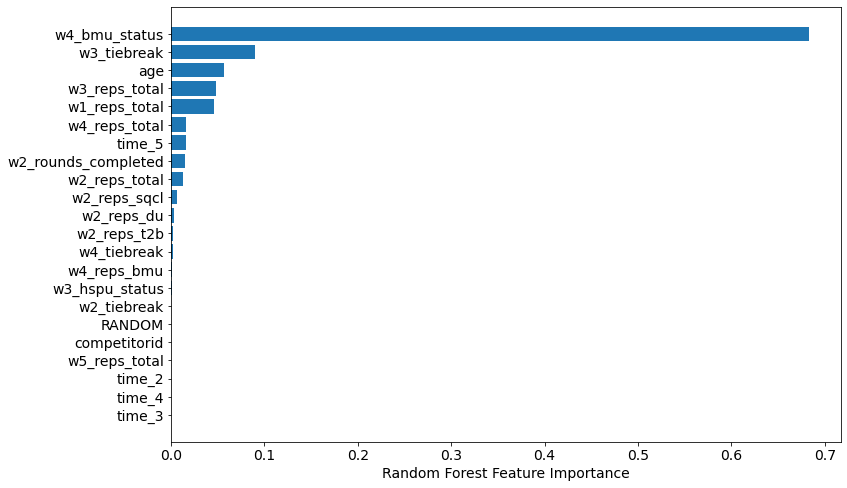

In [26]:
sorted_idx = importance.argsort()
plt.barh(X_sc_mrx.columns[sorted_idx], importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

## Permutation Feature Importance

In [96]:
results = permutation_importance(model, X_train_preprocessed_sc_mrx, y_train_sc_mrx, scoring='r2')

In [97]:
importance = results.importances_mean

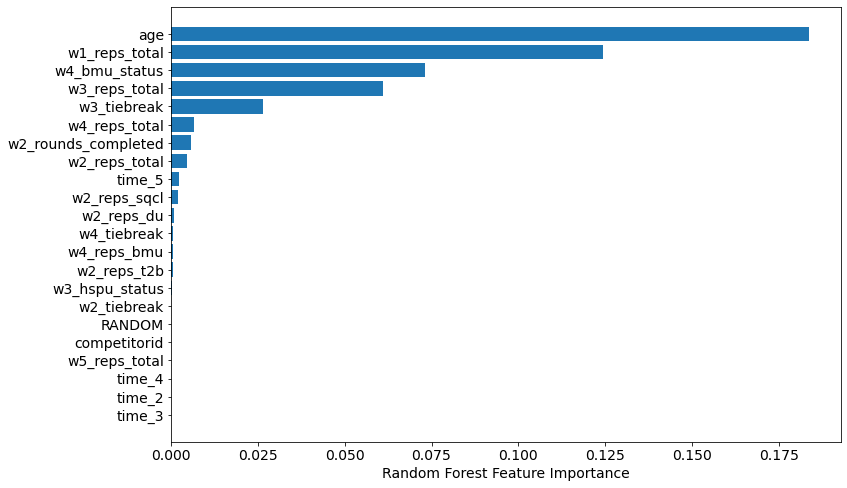

In [98]:
sorted_idx = importance.argsort()
plt.barh(X_sc_mrx.columns[sorted_idx], importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

In [103]:
df = pd.DataFrame(data=y_train_sc_mrx, columns=["id", "rank"],copy=True)

In [104]:
y_train_sc_mrx[:2]

181500     24441
204583    116033
Name: overallrank, dtype: int64

In [105]:
df.head()

,id,rank
